# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
%%time
df_openfoodfacts = pd.read_csv("df_openfoodfacts.csv",sep='\t',low_memory=False).drop(['quantity','serving_size'],axis=1)
df_openfoodfacts.additives_n = [float(x) for x in df_openfoodfacts.additives_n]

CPU times: total: 2.33 s
Wall time: 2.34 s


In [4]:
nbLigne, nbCol = df_openfoodfacts.shape
nbLigne, nbCol

mask = df_openfoodfacts.dtypes.value_counts().reset_index()
mask.rename(columns={'index':'type',0:'Nb'},inplace=True)
nbColInt = mask.Nb[mask.type=='int64']
nbColObject = mask.Nb[mask.type=='object']
nbColFloat64 = mask.Nb[mask.type=='float64']
#nbColDate = mask.Nb[mask.type=='Date']#'object''float64'

In [5]:
print('Le fichier comtient {} variables numeriques et {} varriables catégoriques et {} lignes.'\
      .format(nbColInt.values[0]+nbColFloat64.values[0],nbColObject.values[0],nbLigne ) )

Le fichier comtient 26 variables numeriques et 5 varriables catégoriques et 320749 lignes.


In [6]:
df_openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Data columns (total 31 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     320749 non-null  object 
 1   product_name                             302987 non-null  object 
 2   categories_fr                            84389 non-null   object 
 3   additives_n                              248939 non-null  float64
 4   main_category_fr                         84366 non-null   object 
 5   ingredients_from_palm_oil_n              248939 non-null  float64
 6   ingredients_that_may_be_from_palm_oil_n  248939 non-null  float64
 7   nutrition_grade_fr                       221210 non-null  object 
 8   nutrition-score-fr_100g                  221210 non-null  float64
 9   presenceDeLabels                         320749 non-null  int64  
 10  energy_100g                     

In [7]:
# étende la largeur d'affichage de la colonne pandas df pour permettre une inspection facile
pd.set_option('max_colwidth', 150)
df_openfoodfacts.head()

,code,product_name,categories_fr,additives_n,main_category_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,nutrition-score-fr_100g,presenceDeLabels,...,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,bocal/conserve,creme/sauce,litre,petit pot/yaourt,poids,unité
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.0,0.0000,0.000,0.00000,0,0,0,0,1,0
1,0000000004530,Banana Chips Sweetened (Whole),NaN,0.0,NaN,0.0,0.0,d,14.0,0,...,0.0,0.0214,0.000,0.00129,0,0,0,0,1,0
2,0000000004559,Peanuts,NaN,0.0,NaN,0.0,0.0,b,0.0,0,...,0.0,0.0000,0.071,0.00129,0,0,0,0,1,0
3,0000000016087,Organic Salted Nut Mix,NaN,0.0,NaN,0.0,0.0,d,12.0,0,...,0.0,0.0000,0.143,0.00514,0,0,0,0,1,0
4,0000000016094,Organic Polenta,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0,...,0.0,0.0000,0.000,0.00000,0,0,0,0,1,0


In [8]:
df_openfoodfacts.dtypes.value_counts()

float64    19
int64       7
object      5
dtype: int64

In [12]:
pd.options.display.max_rows=100
df_openfoodfacts\
.drop(columns=['code','product_name','categories_fr','nutrition_grade_fr','main_category_fr'])\
.isna()\
.sum()/nbLigne

additives_n                                0.223882
ingredients_from_palm_oil_n                0.223882
ingredients_that_may_be_from_palm_oil_n    0.223882
nutrition-score-fr_100g                    0.310333
presenceDeLabels                           0.000000
energy_100g                                0.000000
fat_100g                                   0.000000
saturated-fat_100g                         0.000000
trans-fat_100g                             0.000012
cholesterol_100g                           0.000000
carbohydrates_100g                         0.000000
sugars_100g                                0.000022
fiber_100g                                 0.000003
proteins_100g                              0.000009
salt_100g                                  0.000000
sodium_100g                                0.000000
vitamin-a_100g                             0.000003
vitamin-c_100g                             0.000003
calcium_100g                               0.000000
iron_100g   

### Analyse en Composante Principale

In [14]:
from sklearn import preprocessing as prep

X = df_openfoodfacts\
.drop(columns=['code','product_name','categories_fr','nutrition_grade_fr','main_category_fr'])\
.dropna()

std_scale = prep.StandardScaler()
X_scaled = std_scale.fit_transform(X)

#### Calcul des composantes principales

In [15]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=20)
pca.fit(X_scaled)

PCA(n_components=20)

In [16]:
## Selection du nombre de PCs

<AxesSubplot:>

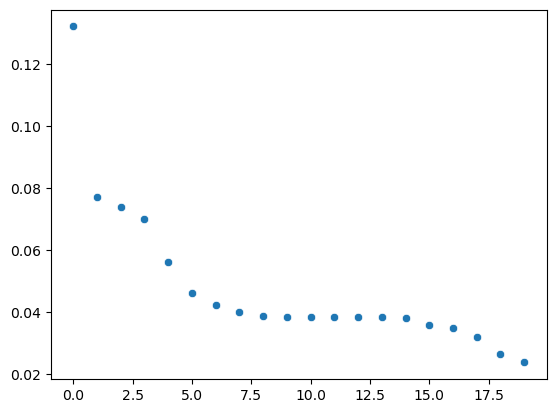

In [17]:
sns.scatterplot(x= range(len(pca.explained_variance_ratio_)),y=pca.explained_variance_ratio_)

#### Pourcentage de variance expliquée

In [20]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.13205637 0.0769522  0.07378295 0.06982126 0.05607529 0.04606606
 0.04219261 0.04003154 0.03872025 0.03848222 0.03848045 0.03847131
 0.03845092 0.03839661 0.0380003  0.035694   0.03486337 0.03201165
 0.02635073 0.02367158]
[0.13205637 0.20900857 0.28279153 0.35261278 0.40868808 0.45475413
 0.49694675 0.53697829 0.57569854 0.61418075 0.65266121 0.69113252
 0.72958344 0.76798005 0.80598035 0.84167435 0.87653772 0.90854936
 0.93490009 0.95857167]


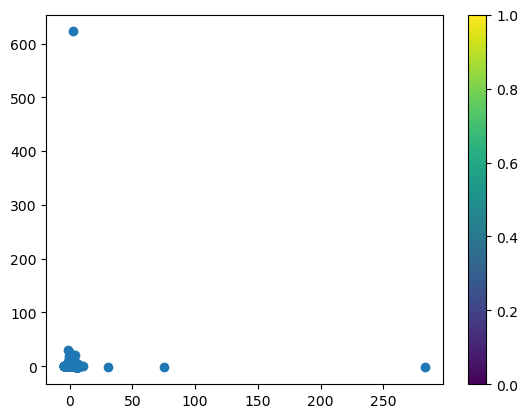

In [21]:
import matplotlib.pyplot as plt


# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'Rank'
    #c=df.Rank
           )

#plt.xlim([-5.5, 5.5])
#plt.ylim([-4, 4])
plt.colorbar()

#### Contribution de chaque variable aux composantes principales

(-0.7, 0.7)

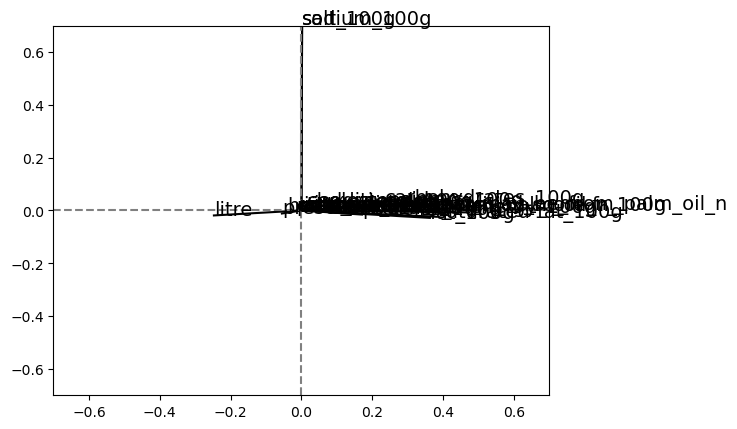

In [22]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

In [26]:
dir(pca)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_features_out',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_feature_names_out',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_features_in_

#### Calcul des composantes principales

### Machine Learning

#### Création matrix de données 

In [ ]:
X = dataset.iloc[:, :-1].values #.values permet d'obtenir un objet
y = dataset.iloc[:, 3].values

#### Echantillonnage

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,  y, 
                                                    test_size = 0.2, # 20% du jeux de données réservé pour test la qualité du model
                                                    random_state = 0)

#### Valeurs manquantes

In [ ]:
# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_train[:, 1:3])
X_train[:, 1:3] = imputer.transform(X_train[:, 1:3])


#### Encodage données categorique

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encoding the Independent Variable
labelencoder_X = LabelEncoder()
X_train[:, 0] = labelencoder_X.fit_transform(X_train[:, 0])

onehotencoder = OneHotEncoder(categorical_features = [0])
X_train = onehotencoder.fit_transform(X_train).toarray()

# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
y_train = labelencoder_y.fit_transform(y_train)

#### Centrage réduction

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)

## Regression lineaire

In [ ]:
from sklearn import linear_model
reglin = linear_model.LinearRegression(fit_intercept = False #car les données sont centrés et réduit z = (x - u) / s
                                      )

In [ ]:
# entrainement du model
reglin.fit(X_train,y_train) 

In [ ]:
#Le coefficient de determination de la prediction
reg.score(X_test, y_test)

## KNN

#### fine tuning

In [ ]:
### KNN
from sklearn.neighbors import KNeighborsClassifier
kmintest = 2
kmaxtotest = 15
errors = []
for k in range(kmintest,kmaxtotest):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # cross validation
    errors.append(100 * (1-knn.fit(X_train,Y_train).score(X_val,Y_val)
                         
plt.plot(range(kmintest,kmaxtotest),errors, 'o-'))
plt.show()

#### meilleur modele

In [ ]:
modelKNN = neighbors.KNeighborsClassifier(n_neighbors=k_best).fit(X_train,Y_train)

#### performance modele

In [ ]:
modelKNN.score(X_test, y_test)

In [ ]:
error = round((1 - modelKNN.score(xtest, ytest)) *100,ndigits=2)
print('Erreur: %f' % error)

In [1]:
wait

NameError: name 'wait' is not defined